# imports

In [ ]:
# !pip install pandas
# !pip install openpyxl
# !pip install requests
# !pip install tqdm
# !pip install seaborn
# !pip install -U tsfresh
# !pip install --upgrade "setuptools<81"
# !pip install numpy==1.26.4
# !pip install numba
# !pip install ydata-profiling
# !pip install ipywidgets


In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import random

from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features, select_features

from ydata_profiling import ProfileReport



from main import create_new_weather_columns, expand_df_to_daily
from config import regions_coords


# Создание df

In [88]:
RANDOM_STATE = 239

df = pd.read_excel("target.xlsx", sheet_name="data cleaned")
df.drop("start_date", axis=1, inplace=True)

In [89]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['state'])
df_encoded.head(2)

,year,month,nps,state_Алтайский край,state_Амурская область,state_Архангельская область,state_Астраханская область,state_Брянская область,state_Владимирская область,state_Волгоградская область,...,state_Томская область,state_Тульская область,state_Тюменская область,state_Ульяновская область,state_Хабаровский край,state_Ханты-Мансийский автономный округ - Югра,state_Челябинская область,state_Чеченская Республика,state_Чувашская Республика - Чувашия,state_Ярославская область
0,2024,10,8,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2024,10,10,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [90]:
df_weather_grouped = df.groupby(['year', 'month', 'state'], as_index=False)['nps'].mean()
df_weather_grouped = create_new_weather_columns(df_weather_grouped, cache_path='../cache/weather_cache.pkl')

df_weather_grouped_encoded = pd.get_dummies(df_weather_grouped, columns=['state']) # One-Hot Encoding
df_weather_grouped_encoded.head(2)

Cache file '../cache/weather_cache.pkl' успешно загружен.


Processing rows: 100%|██████████| 715/715 [00:00<00:00, 41021.63it/s]

Cache saved to ../cache/weather_cache.pkl


,year,month,nps,temp_max_avg,temp_min_avg,precipitation_sum,wind_speed_max_avg,humidity_max_avg,humidity_mean_avg,cloudcover_avg,...,state_Томская область,state_Тульская область,state_Тюменская область,state_Ульяновская область,state_Хабаровский край,state_Ханты-Мансийский автономный округ - Югра,state_Челябинская область,state_Чеченская Республика,state_Чувашская Республика - Чувашия,state_Ярославская область
0,2024,1,7.23,-9.746774,-18.648387,1.403226,19.575806,85.241935,78.887097,73.403226,...,False,False,False,False,False,False,False,False,False,False
1,2024,1,7.57,-17.074194,-25.019355,0.229032,13.912903,79.112903,71.145161,40.516129,...,False,False,False,False,False,False,False,False,False,False


In [91]:
df_weather = create_new_weather_columns(df, cache_path='../cache/weather_cache.pkl')
df_weather.head(2)

Cache file '../cache/weather_cache.pkl' успешно загружен.


Processing rows: 100%|██████████| 71500/71500 [00:01<00:00, 46751.65it/s]


Cache saved to ../cache/weather_cache.pkl


,year,month,nps,state,temp_max_avg,temp_min_avg,precipitation_sum,wind_speed_max_avg,humidity_max_avg,humidity_mean_avg,cloudcover_avg,solar_radiation_sum,snowfall_sum,days_clear,days_cloudy,days_rain_drizzle,days_snow
0,2024,10,8,Алтайский край,10.759016,2.393443,1.714754,18.355738,90.852459,73.590164,63.819672,9.105902,0.20082,2,24,27,8
1,2024,10,10,Алтайский край,10.759016,2.393443,1.714754,18.355738,90.852459,73.590164,63.819672,9.105902,0.20082,2,24,27,8


In [92]:
df_weather_daily = expand_df_to_daily(df_weather_grouped, regions_coords, cache_path='../cache/weather_cache_daily.pkl')
df_weather_daily.head(3)

Cache file '../cache/weather_cache_daily.pkl' успешно загружен.


Expanding months to days: 100%|██████████| 715/715 [00:00<00:00, 1725.64it/s]


Cache saved to ../cache/weather_cache_daily.pkl


,date,temp_max,temp_min,precipitation,wind_speed_max,weathercode,humidity_max,humidity_mean,cloudcover,solar_radiation,...,wind_speed_max_avg,humidity_max_avg,humidity_mean_avg,cloudcover_avg,solar_radiation_sum,snowfall_sum,days_clear,days_cloudy,days_rain_drizzle,days_snow
0,2024-01-01,-0.4,-9.2,2.4,28.2,73,91,85,96,1.13,...,19.575806,85.241935,78.887097,73.403226,3.014355,0.791452,2,28,0,32
1,2024-01-02,0.5,-1.4,7.5,28.0,73,90,84,100,0.77,...,19.575806,85.241935,78.887097,73.403226,3.014355,0.791452,2,28,0,32
2,2024-01-03,-1.3,-21.4,1.7,32.2,73,86,75,99,2.05,...,19.575806,85.241935,78.887097,73.403226,3.014355,0.791452,2,28,0,32


In [93]:
df_weather_daily['day'] = df_weather_daily['date'].str.slice(start=8, stop=10).astype(int)
df_weather_daily = df_weather_daily.drop(columns=["start_date"], axis=1)
df_weather_daily.head(1)

,date,temp_max,temp_min,precipitation,wind_speed_max,weathercode,humidity_max,humidity_mean,cloudcover,solar_radiation,...,humidity_max_avg,humidity_mean_avg,cloudcover_avg,solar_radiation_sum,snowfall_sum,days_clear,days_cloudy,days_rain_drizzle,days_snow,day
0,2024-01-01,-0.4,-9.2,2.4,28.2,73,91,85,96,1.13,...,85.241935,78.887097,73.403226,3.014355,0.791452,2,28,0,32,1


# Смотрим на df

In [94]:
# profile = ProfileReport(df_weather_daily, title="Profiling Report for Weather Data", explorative=True, minimal=False)
# profile.to_notebook_iframe()

In [95]:
df_target = df_weather_grouped[["year", "month", "state", "nps"]].copy()
df_target_2024 = df_target[df_target["year"] == 2024].copy()
big_states = ["Москва", "Московская область", "Санкт-Петербург", "Краснодарский край", "Ростовская область"]
df_target_2024.head(4)

,year,month,state,nps
0,2024,1,Алтайский край,7.23
1,2024,1,Амурская область,7.57
2,2024,1,Архангельская область,6.71
3,2024,1,Астраханская область,7.58


/var/folders/xw/9_n9rd5d57g4q61j9xkyrmvm0000gn/T/ipykernel_13564/1704309862.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(states))  # палитра цветов


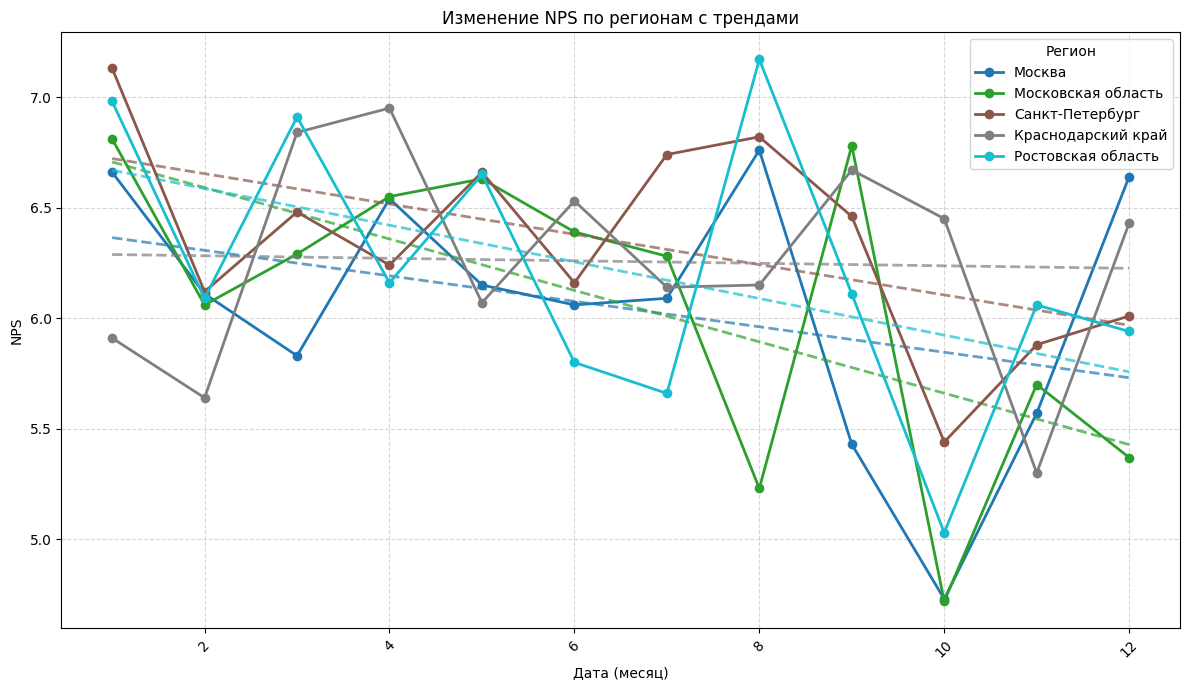

In [96]:
plt.figure(figsize=(12, 7))
states = big_states

colors = plt.cm.get_cmap('tab10', len(states))  # палитра цветов

for i, region in enumerate(states):
    region_data = df_target_2024[df_target_2024["state"] == region].sort_values("month")
    x = np.arange(len(region_data))
    y = region_data["nps"].values

    plt.plot(region_data["month"], y, marker="o", label=region, color=colors(i), linewidth=2)

    coeffs = np.polyfit(x, y, 1)
    trendline = np.poly1d(coeffs)(x)
    plt.plot(region_data["month"], trendline, linestyle="--", color=colors(i), linewidth=2, alpha=0.7)

plt.title("Изменение NPS по регионам с трендами")
plt.xlabel("Дата (месяц)")
plt.ylabel("NPS")
plt.legend(title="Регион", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/xw/9_n9rd5d57g4q61j9xkyrmvm0000gn/T/ipykernel_13564/51868692.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(states))


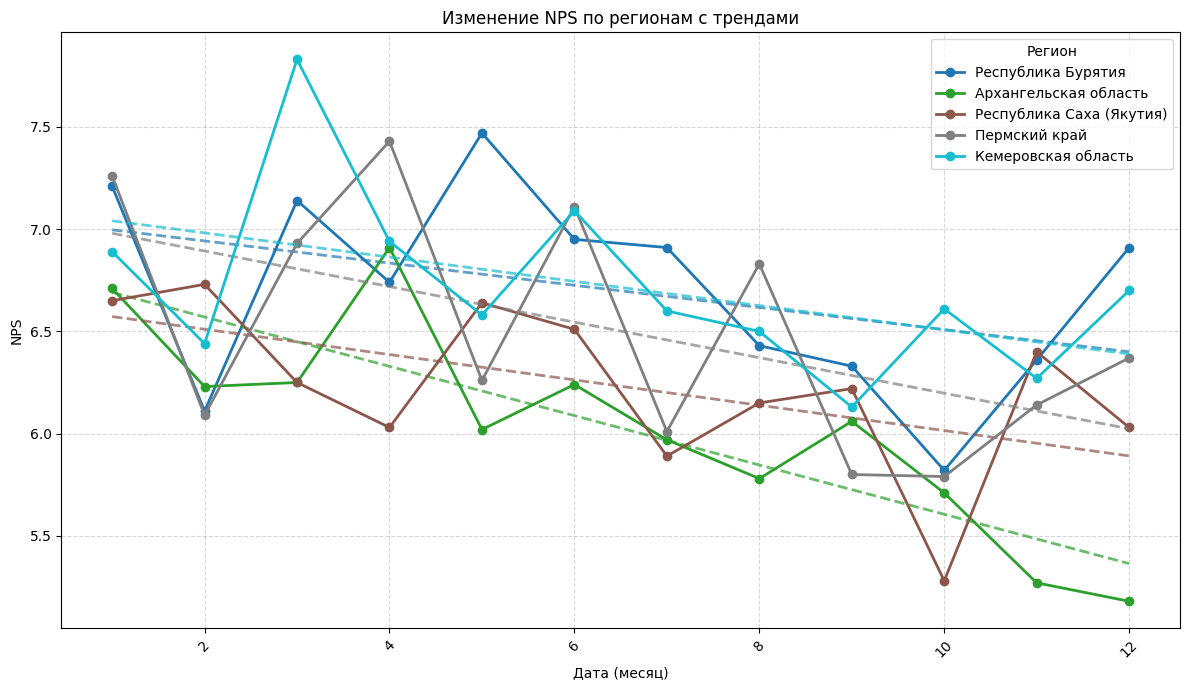

In [97]:
plt.figure(figsize=(12, 7))
random_states = random.sample(list(df_target_2024["state"].unique()), 5)
states = random_states

colors = plt.cm.get_cmap('tab10', len(states))

for i, region in enumerate(states):
    region_data = df_target_2024[df_target_2024["state"] == region].sort_values("month")
    x = np.arange(len(region_data))
    y = region_data["nps"].values

    plt.plot(region_data["month"], y, marker="o", label=region, color=colors(i), linewidth=2)

    coeffs = np.polyfit(x, y, 1)
    trendline = np.poly1d(coeffs)(x)
    plt.plot(region_data["month"], trendline, linestyle="--", color=colors(i), linewidth=2, alpha=0.7)

plt.title("Изменение NPS по регионам с трендами")
plt.xlabel("Дата (месяц)")
plt.ylabel("NPS")
plt.legend(title="Регион", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На графике NPS можно заметить следующие закономерности:

1. Сезонные колебания: Значения NPS могут изменяться в зависимости от времени года. Например, в летние месяцы (июнь, июль, август) может наблюдаться рост NPS, а в зимние месяцы — снижение.

2. Тренды: Для некоторых регионов можно увидеть общий тренд - снижение NPS на протяжении года.

3. Аномалии: На графике могут быть видны резкие скачки или падения NPS в определённые месяцы. Перерасчет цен тарифов в феврале (~2) и что-то случилось в ~10 месяце

# ML

In [98]:
X = df_weather_grouped_encoded.drop('nps', axis=1)
y = df_weather_grouped_encoded['nps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [99]:
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)


model.fit(X_train, y_train)

RandomForestRegressor(random_state=239)

In [100]:
y_pred = model.predict(X_test)

In [101]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.3533654217482516


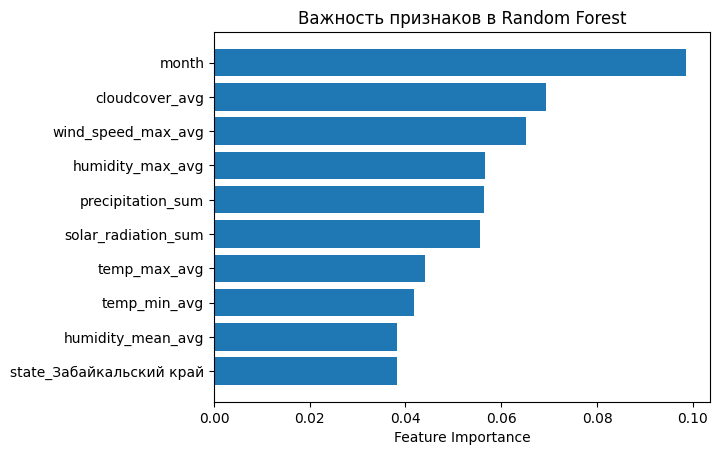

In [102]:
importances = model.feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=True)

plt.barh(feature_importances['feature'][-10:], feature_importances['importance'][-10:])
plt.xlabel('Feature Importance')
plt.title('Важность признаков в Random Forest')
plt.show()

# tsfresh по месяцам (безуспешно)


In [82]:
# df_weather['id'] = df_weather['state'] + '_' + df_weather['year'].astype(str) + '_' + df_weather['month'].astype(str)

# features_to_extract = [
#     'temp_max_avg', 'temp_min_avg', 'precipitation_sum', 'wind_speed_max_avg',
#     'humidity_max_avg', 'humidity_mean_avg', 'cloudcover_avg', 'solar_radiation_sum',
#     'snowfall_sum', 'days_clear', 'days_cloudy', 'days_rain_drizzle', 'days_snow'
# ]

# df_long = pd.melt(
#     df_weather,
#     id_vars=['id', 'start_date'],
#     value_vars=features_to_extract,
#     var_name='kind',
#     value_name='value'
# ).rename(columns={'start_date': 'time'})

# extracted_features = extract_features(
#     df_long,
#     column_id='id',
#     column_sort='time',
#     column_kind='kind',
#     column_value='value',
#     impute_function=impute,
#     show_warnings=False
# )

# extracted_features.head()

In [83]:
# y = df_weather.groupby('id')['nps'].mean()
# print(extracted_features.index.equals(y.index))
# selected_features = select_features(extracted_features, y)
# selected_features

Ни один признак не прошёл отбор

# tsfresh - по дням (безуспешно)

In [84]:
y = df_weather_daily["nps"]

df_weather_daily["id"] = df_weather_daily["state"]

y_id = df_weather_daily.groupby("id")["nps"].mean()

df_weather_daily = df_weather_daily.drop(columns=["state", "year", "month", "day", "nps"])
df_weather_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21835 entries, 0 to 21834
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 21835 non-null  object 
 1   temp_max             21835 non-null  float64
 2   temp_min             21835 non-null  float64
 3   precipitation        21835 non-null  float64
 4   wind_speed_max       21835 non-null  float64
 5   weathercode          21835 non-null  int64  
 6   humidity_max         21835 non-null  int64  
 7   humidity_mean        21835 non-null  int64  
 8   cloudcover           21835 non-null  int64  
 9   solar_radiation      21835 non-null  float64
 10  snowfall             21835 non-null  float64
 11  temp_max_avg         21835 non-null  float64
 12  temp_min_avg         21835 non-null  float64
 13  precipitation_sum    21835 non-null  float64
 14  wind_speed_max_avg   21835 non-null  float64
 15  humidity_max_avg     21835 non-null 

In [85]:
features = extract_features(
    df_weather_daily,
    column_id="id",
    column_sort="date",
    disable_progressbar=False
)

features = impute(features)
features.head(3)

Feature Extraction:   0%|          | 0/20 [00:00<?, ?it/s]/Users/rokerius/Library/Python/3.9/lib/python/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/rokerius/Library/Python/3.9/lib/python/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/rokerius/Library/Python/3.9/lib/python/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal

,solar_radiation__variance_larger_than_standard_deviation,solar_radiation__has_duplicate_max,solar_radiation__has_duplicate_min,solar_radiation__has_duplicate,solar_radiation__sum_values,solar_radiation__abs_energy,solar_radiation__mean_abs_change,solar_radiation__mean_change,solar_radiation__mean_second_derivative_central,solar_radiation__median,...,cloudcover__fourier_entropy__bins_5,cloudcover__fourier_entropy__bins_10,cloudcover__fourier_entropy__bins_100,cloudcover__permutation_entropy__dimension_3__tau_1,cloudcover__permutation_entropy__dimension_4__tau_1,cloudcover__permutation_entropy__dimension_5__tau_1,cloudcover__permutation_entropy__dimension_6__tau_1,cloudcover__permutation_entropy__dimension_7__tau_1,cloudcover__query_similarity_count__query_None__threshold_0.0,cloudcover__mean_n_absolute_max__number_of_maxima_7
Алтайский край,1.0,0.0,0.0,1.0,4439.30,76041.6032,2.688636,0.006212,0.001734,9.60,...,0.636740,1.125924,3.151767,1.757295,3.044453,4.387409,5.425441,5.872979,0.0,100.0
Амурская область,1.0,0.0,0.0,1.0,4916.58,83443.6314,2.708864,0.010884,-0.000456,11.06,...,1.119821,1.771094,3.808475,1.772412,3.117180,4.573109,5.572370,5.890706,0.0,100.0
Архангельская область,1.0,0.0,1.0,1.0,3212.08,54607.7250,2.319621,0.001035,0.000342,4.35,...,0.090729,0.200814,2.062929,1.746789,3.055946,4.432816,5.456111,5.827579,0.0,100.0


In [86]:
y_id = y_id.loc[features.index]

selected_features = select_features(features, y_id)
selected_features.head(10)

/Users/rokerius/Library/Python/3.9/lib/python/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/rokerius/Library/Python/3.9/lib/python/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/rokerius/Library/Python/3.9/lib/python/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package o

""
Алтайский край
Амурская область
Архангельская область
Астраханская область
Брянская область
Владимирская область
Волгоградская область
Вологодская область
Воронежская область
Забайкальский край
